# EE 344 — Assignment 5: Power-System Fault Classification with Deep Neural Networks

In this assignment, you will predict **power-system fault conditions** from 6 input measurements using **PyTorch**.
There are many ways to implement DNNs for prediction tasks; here you will implement and compare **three** common setups.

**Dataset**: `classData.csv`

**Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`  
**Outputs**: 4-bit label `[G, C, B, A]`

Dataset (Kaggle): https://www.kaggle.com/datasets/esathyaprakash/electrical-fault-detection-and-classification

**Note:** Do **NOT** download the dataset from Kaggle. Use the dataset file provided on Canvas with this assignment.

Your tasks:
1. **Part 1** — Regression-style DNN to predict 4 outputs (then round to bits).
2. **Part 2** — Multi-label DNN to predict 4 bits (sigmoid / BCE-style loss).
3. **Part 3** — Multi-class DNN to predict no fault and 5 fault types (softmax / cross-entropy).
4. **Part 4** — Brief discussion: which approach is best and why.
5. **Part 5** — Open-ended: build a **binary** classifier (Fault vs No Fault) using the best approach.


## Setup
Run the next cell to import libraries and define helper functions.

In [74]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def plot_cm(cm, title, labels):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha='right')
    plt.yticks(ticks, labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def bit_reports(Y_true_bits, Y_pred_bits, split_name='Test', bit_names=('G','C','B','A')):
    """Multi-label report + per-bit 2x2 confusion matrices."""
    print(f"\n=== Bit-level Report | {split_name} ===")
    print(classification_report(Y_true_bits, Y_pred_bits, target_names=list(bit_names), digits=4))
    for j, lab in enumerate(bit_names):
        cm = confusion_matrix(Y_true_bits[:, j], Y_pred_bits[:, j], labels=[0, 1])
        print(f"\nBit {lab} | {split_name} CM (rows=true 0/1, cols=pred 0/1):\n{cm}")


Device: cpu


## Dataset

The file `classData.csv` contains a dataset for classifying fault conditions.

- **Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`
- **Outputs**: `[G, C, B, A]`

Examples:
- `[0 0 0 0]` — No Fault
- `[1 0 0 1]` — LG fault (Phase A to ground)
- `[0 0 1 1]` — LL fault (Phase A to Phase B)
- `[1 0 1 1]` — LLG fault (Phases A,B to ground)
- `[0 1 1 1]` — LLL fault (all three phases)
- `[1 1 1 1]` — LLLG fault (three phases + ground)


In [75]:
# ----------------------------
# Load data + create targets
# ----------------------------
CSV_PATH = 'classData.csv'
df = pd.read_csv(CSV_PATH)

label_cols = ['G','C','B','A']
feature_cols = ['Ia','Ib','Ic','Va','Vb','Vc']

missing = [c for c in (label_cols + feature_cols) if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}. Found: {list(df.columns)}")

X = df[feature_cols].astype(np.float32).values            # (N,6)
Y_bits = df[label_cols].astype(int).values                # (N,4)

FAULT_NAMES = ['No Fault','LG','LL','LLG','LLL','LLLG']

def bits_to_fault_type_idx(bits_gcba):
    G, C, B, A = map(int, bits_gcba)
    n_phase = C + B + A
    if G == 0 and n_phase == 0: return 0
    if G == 1 and n_phase == 1: return 1
    if G == 0 and n_phase == 2: return 2
    if G == 1 and n_phase == 2: return 3
    if G == 0 and n_phase == 3: return 4
    if G == 1 and n_phase == 3: return 5
    raise ValueError(f"Unexpected pattern [G,C,B,A]={bits_gcba}")

y_fault = np.array([bits_to_fault_type_idx(row) for row in Y_bits], dtype=int)
print('Fault counts:', dict(zip(FAULT_NAMES, np.bincount(y_fault, minlength=len(FAULT_NAMES)))))

# One shared split (recommended for fair comparison across Parts 1–3)
X_train, X_test, Y_train, Y_test, y_fault_train, y_fault_test = train_test_split(
    X, Y_bits, y_fault, test_size=0.30, random_state=RANDOM_STATE, stratify=y_fault
)
print('Train size:', X_train.shape[0], '| Test size:', X_test.shape[0])


Fault counts: {'No Fault': np.int64(2365), 'LG': np.int64(1129), 'LL': np.int64(1004), 'LLG': np.int64(1134), 'LLL': np.int64(1096), 'LLLG': np.int64(1133)}
Train size: 5502 | Test size: 2359


## Part 1 — DNN Model 1 (Regression-style 4-output model)

You will build a DNN that outputs **4 real-valued numbers** and train it with **MSE**.
During evaluation, you will **round** predictions to the nearest integer, clamp to `{0,1}`, and then compare against the true 4-bit label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 (linear)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**


In [76]:
# ----------------------------
# Part 1: Robust scaling (fit on train only)
# ----------------------------
scaler_1 = RobustScaler()
X_train_s1 = scaler_1.fit_transform(X_train).astype(np.float32)
X_test_s1  = scaler_1.transform(X_test).astype(np.float32)

# Torch datasets
Xtr = torch.from_numpy(X_train_s1)
Xte = torch.from_numpy(X_test_s1)
Ytr = torch.from_numpy(Y_train.astype(np.float32))
Yte = torch.from_numpy(Y_test.astype(np.float32))

BATCH_SIZE = 256
train_loader_1 = DataLoader(TensorDataset(Xtr, Ytr), batch_size=BATCH_SIZE, shuffle=True)

# Hyperparameters
INPUT_DIM = 6
H1 = 16
H2 = 8
OUT_DIM = 4
DROPOUT_P = 0.25
L2_WEIGHT_DECAY = 1e-4
LR = 1e-3
EPOCHS = 1000


In [77]:
## [ TODO 1 ]
# Define the DNN for Part 1 using PyTorch.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: linear (no activation)
# - Use BatchNorm and Dropout in hidden layers
#
# Write your model class below.

class DNN_Reg4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.drop1 = nn.Dropout(p_drop)
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.drop2 = nn.Dropout(p_drop)
        self.fc_out = nn.Linear(h2, out_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.drop2(x)
        x = self.fc_out(x)
        return x


In [78]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: MSE
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

model = DNN_Reg4(
    input_dim=INPUT_DIM,
    h1=H1,
    h2=H2,
    out_dim=OUT_DIM,
    p_drop=DROPOUT_P
).to(device)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LR,
    weight_decay=L2_WEIGHT_DECAY # L2 regularization
)


In [79]:
# ----------------------------
# Training loop (you fill the key missing pieces)
# ----------------------------
## [ TODO 3 ]
def train_part1(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # zero gradients
            optimizer.zero_grad()
            # forward pass
            preds = model(xb)
            # compute loss
            loss = loss_fn(preds, yb)
            # backward
            loss.backward()
            # optimizer step
            optimizer.step()

            total += loss.item() * xb.size(0)


        if ep in [1, epochs//2, epochs]:
            # print epoch + average loss
            avg_loss = total / len(loader.dataset)
            print(f"Epoch {ep}/{epochs} | Loss: {avg_loss:.6f}")

@torch.no_grad()
def predict_part1(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    out = model(X_t).cpu().numpy()  # (N,4) real-valued
    return out

# Train the model
train_part1(model, train_loader_1)


Epoch 1/1000 | Loss: 0.692231
Epoch 500/1000 | Loss: 0.209960
Epoch 1000/1000 | Loss: 0.202687


In [80]:
# ----------------------------
# Evaluation (round -> clamp to {0,1} -> report)
# ----------------------------
yhat_train = predict_part1(model, X_train_s1)
yhat_test  = predict_part1(model, X_test_s1)

# After you obtain yhat_* (shape N x 4):
pred_bits_train = np.clip(np.rint(yhat_train).astype(int), 0, 1)
pred_bits_test  = np.clip(np.rint(yhat_test ).astype(int), 0, 1)
bit_reports(Y_train, pred_bits_train, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     1.0000    0.6786    0.8085      2377
           C     1.0000    0.9094    0.9526      2263
           B     0.9982    0.9267    0.9612      3057
           A     1.0000    0.9666    0.9830      3144

   micro avg     0.9995    0.8803    0.9361     10841
   macro avg     0.9996    0.8703    0.9263     10841
weighted avg     0.9995    0.8803    0.9322     10841
 samples avg     0.6848    0.6290    0.6513     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[3125    0]
 [ 764 1613]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3239    0]
 [ 205 2058]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2440    5]
 [ 224 2833]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2358    0]
 [ 105 3039]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     1.0000    0.6683    0.8012      1019
           C     1.0000    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

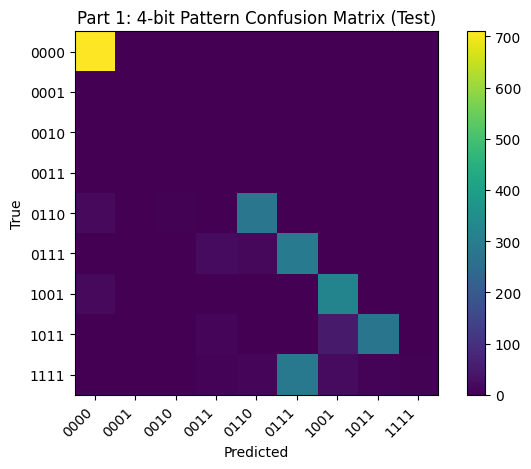

[[710   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 19   0   4   0 278   0   0   0   0]
 [  0   0   0  20  15 294   0   0   0]
 [ 18   2   0   0   0   0 319   0   0]
 [  1   1   0   9   0   0  52 277   0]
 [  0   0   0   8  12 287  22   6   5]]


In [81]:
# One confusion matrix over full 4-bit patterns (for TEST set)
true_str = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str = [''.join(map(str, r.tolist())) for r in pred_bits_test]
labels = sorted(list(set(true_str) | set(pred_str)))
cm = confusion_matrix(true_str, pred_str, labels=labels)
plot_cm(cm, 'Part 1: 4-bit Pattern Confusion Matrix (Test)', labels)
print(cm)

## Part 2 — DNN Model 2 (Multi-label 4-bit classification)

You will build a DNN that predicts the 4 bits `[G, C, B, A]` as a **multi-label** output.
Each output dimension is an independent binary label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 logits (apply sigmoid only for evaluation)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use a **binary cross-entropy style loss on logits** (do not apply sigmoid inside the model).


In [82]:
# ----------------------------
# Part 2: Robust scaling (fit on train only)
# ----------------------------
scaler_2 = RobustScaler()
X_train_s2 = scaler_2.fit_transform(X_train).astype(np.float32)
X_test_s2  = scaler_2.transform(X_test).astype(np.float32)

Xtr2 = torch.from_numpy(X_train_s2)
Xte2 = torch.from_numpy(X_test_s2)
Ytr2 = torch.from_numpy(Y_train.astype(np.float32))
Yte2 = torch.from_numpy(Y_test.astype(np.float32))

train_loader_2 = DataLoader(TensorDataset(Xtr2, Ytr2), batch_size=BATCH_SIZE, shuffle=True)


In [83]:
## [ TODO 1 ]
# Define the DNN for Part 2.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: 4 logits (no sigmoid inside the model)
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiLabel4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        # define layers
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.drop1 = nn.Dropout(p_drop)
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.drop2 = nn.Dropout(p_drop)
        self.fc_out = nn.Linear(h2, out_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        # forward pass returning logits (N,4)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.drop2(x)
        # (N,4)
        logits = self.fc_out(x)
        return logits


In [84]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: binary cross-entropy style loss on logits -- BCEWithLogitsLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

model = DNN_MultiLabel4(
    input_dim=INPUT_DIM,
    h1=H1,
    h2=H2,
    out_dim=OUT_DIM,
    p_drop=DROPOUT_P
).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LR,
    weight_decay=L2_WEIGHT_DECAY
)


In [85]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3]
def train_part2(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # zero gradients
            optimizer.zero_grad()

            # foward pass
            logits = model(xb)

            # loss on logits vs targets
            loss = loss_fn(logits, yb)

            # backward + step
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)

        if ep in [1, epochs//2, epochs]:
            avg_loss = total / len(loader.dataset)
            print(f"Epoch {ep}/{epochs} | Loss: {avg_loss:.6f}")


@torch.no_grad()
def predict_bits_part2(model, X_np, threshold=0.5):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy()
    pred_bits = (probs >= threshold).astype(int)
    return pred_bits

# Train the model
train_part2(model, train_loader_2)


Epoch 1/1000 | Loss: 0.708954
Epoch 500/1000 | Loss: 0.218260
Epoch 1000/1000 | Loss: 0.201429


In [86]:
# ----------------------------
# Evaluation
# ----------------------------
pred_bits_train_ = predict_bits_part2(model, X_train_s2)
pred_bits_test_  = predict_bits_part2(model, X_test_s2)

bit_reports(Y_train, pred_bits_train_, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test_,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.8363    0.8443    0.8403      2377
           C     1.0000    0.9129    0.9545      2263
           B     0.9975    0.9313    0.9633      3057
           A     0.9997    0.9777    0.9886      3144

   micro avg     0.9614    0.9219    0.9412     10841
   macro avg     0.9584    0.9166    0.9367     10841
weighted avg     0.9633    0.9219    0.9418     10841
 samples avg     0.6679    0.6510    0.6548     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2732  393]
 [ 370 2007]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3239    0]
 [ 197 2066]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2438    7]
 [ 210 2847]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2357    1]
 [  70 3074]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.8373    0.8283    0.8328      1019
           C     1.0000    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

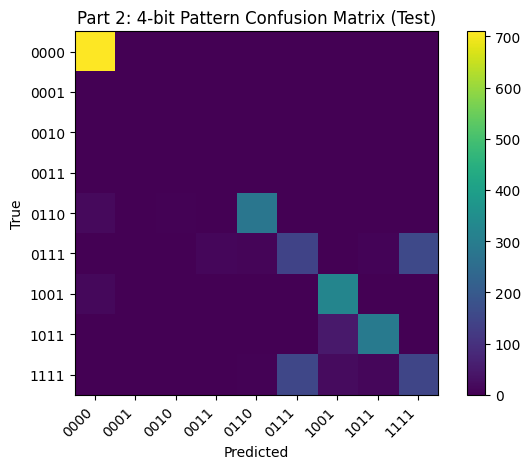

[[710   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 18   0   4   0 279   0   0   0   0]
 [  0   0   0  13  10 142   0   7 157]
 [ 15   2   0   0   0   0 322   0   0]
 [  0   1   0   0   0   0  48 291   0]
 [  0   0   0   0   5 152  22  12 149]]


In [87]:
# One confusion matrix over full 4-bit patterns (For TEST set)
true_str_ = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str_ = [''.join(map(str, r.tolist())) for r in pred_bits_test_]
labels_ = sorted(list(set(true_str_) | set(pred_str_)))
cm_ = confusion_matrix(true_str_, pred_str_, labels=labels_)
plot_cm(cm_, 'Part 2: 4-bit Pattern Confusion Matrix (Test)', labels_)
print(cm_)

## Part 3 — DNN Model 3 (Multi-class fault type classification)

In this part, you will predict one of **6 fault types**.
The 4-bit label is converted to a single class in `{0,1,2,3,4,5}` using the provided mapping.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 6 logits
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use **cross-entropy loss** for multi-class classification.


In [88]:
# ----------------------------
# Part 3: Robust scaling (fit on train only)
# ----------------------------
scaler_3 = RobustScaler()
X_train_s3 = scaler_3.fit_transform(X_train).astype(np.float32)
X_test_s3  = scaler_3.transform(X_test).astype(np.float32)

ytr3 = torch.from_numpy(y_fault_train.astype(np.int64))
yte3 = torch.from_numpy(y_fault_test.astype(np.int64))
Xtr3 = torch.from_numpy(X_train_s3)
Xte3 = torch.from_numpy(X_test_s3)

train_loader_3 = DataLoader(TensorDataset(Xtr3, ytr3), batch_size=BATCH_SIZE, shuffle=True)


In [89]:
## [ TODO 1 ]
# Define the DNN for Part 3.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 6
# - Hidden activations: ReLU
# - Output: 6 logits
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiClass6(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, num_classes=6, p_drop=DROPOUT_P):
        super().__init__()
        # define layers
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.drop1 = nn.Dropout(p_drop)
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.drop2 = nn.Dropout(p_drop)
        self.fc_out = nn.Linear(h2, num_classes)
        self.act = nn.ReLU()

    def forward(self, x):
        # forward pass returning logits (N,6)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.drop2(x)
        # (N,6)
        logits = self.fc_out(x)
        return logits


In [90]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: CrossEntropyLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

model = DNN_MultiClass6(
    input_dim=INPUT_DIM,
    h1=H1,
    h2=H2,
    num_classes=6,
    p_drop=DROPOUT_P
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LR,
    weight_decay=L2_WEIGHT_DECAY
)


In [91]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3 ]
def train_part3(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # zero gradients
            optimizer.zero_grad()

            logits = model(xb)

            loss = loss_fn(logits, yb)

            # backward + step
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)

        if ep in [1, epochs//2, epochs]:
            # print epoch + average loss
            avg_loss = total / len(loader.dataset)
            print(f"Epoch {ep}/{epochs} | Loss: {avg_loss:.6f}")

@torch.no_grad()
def predict_part3(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    return torch.argmax(logits, dim=1).cpu().numpy()

# Train the model
train_part3(model, train_loader_3)


Epoch 1/1000 | Loss: 1.851715
Epoch 500/1000 | Loss: 0.596192
Epoch 1000/1000 | Loss: 0.607084



=== Part 3 | Train ===
              precision    recall  f1-score   support

    No Fault     0.9484    1.0000    0.9735      1655
          LG     0.8594    0.9443    0.8999       790
          LL     0.9038    0.9360    0.9196       703
         LLG     0.8829    0.9018    0.8922       794
         LLL     0.5426    0.5150    0.5284       767
        LLLG     0.5048    0.3960    0.4438       793

    accuracy                         0.8150      5502
   macro avg     0.7737    0.7822    0.7763      5502
weighted avg     0.8000    0.8150    0.8059      5502



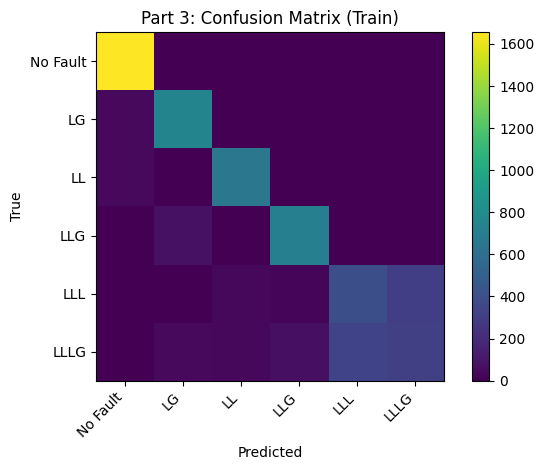


=== Part 3 | Test ===
              precision    recall  f1-score   support

    No Fault     0.9441    1.0000    0.9713       710
          LG     0.8645    0.9410    0.9011       339
          LL     0.9094    0.9336    0.9213       301
         LLG     0.9059    0.9059    0.9059       340
         LLL     0.5143    0.4924    0.5031       329
        LLLG     0.4854    0.3912    0.4332       340

    accuracy                         0.8109      2359
   macro avg     0.7706    0.7773    0.7727      2359
weighted avg     0.7967    0.8109    0.8026      2359



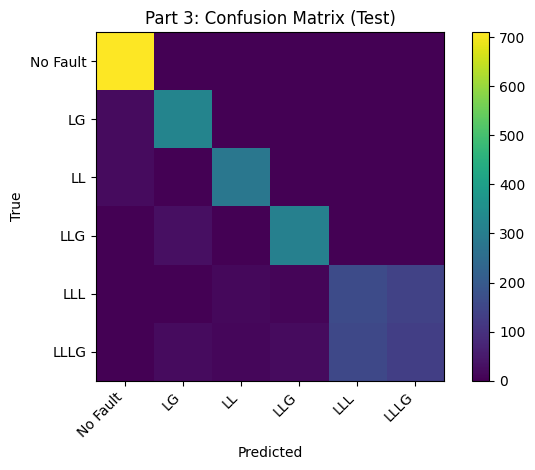

In [92]:
# ----------------------------
# Evaluation
# ----------------------------
pred_train = predict_part3(model, X_train_s3)
pred_test  = predict_part3(model, X_test_s3)

print('\n=== Part 3 | Train ===')
print(classification_report(y_fault_train, pred_train, target_names=FAULT_NAMES, digits=4))
cm_tr = confusion_matrix(y_fault_train, pred_train, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_tr, 'Part 3: Confusion Matrix (Train)', FAULT_NAMES)

print('\n=== Part 3 | Test ===')
print(classification_report(y_fault_test, pred_test, target_names=FAULT_NAMES, digits=4))
cm_te = confusion_matrix(y_fault_test, pred_test, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_te, 'Part 3: Confusion Matrix (Test)', FAULT_NAMES)


## Part 4 — Discussion

Answer **2–5 sentences** for each prompt.

1. Compare Parts 1–3. Which formulation fits this dataset best (regression-style, multi-label, or multi-class), and why?
2. When you used the bit-based approaches (Part 1 and Part 2), did you observe any **inconsistent 4-bit outputs** (invalid fault patterns)? What does that suggest?
3. Looking at confusion matrices, which fault types (or bit positions) were the hardest to predict? Give one plausible reason.

### Your answers
- Q1: For this dataset the multi-class formulation in part 3 performed the best. The test metric in part 1 and 2 was around 0.65, while it was around 0.77 in part 3. The regression and multi-label models aren't as good in this case at getting the 4-bit labels correct.
- Q2: Yes there were invalid fault patterns in the bit-based approaches. The pattern 0110 is an invalid pattern. This suggests the bit-based approaches don't respect the contraints of the fault labels since they are creating labels that don't exist.
- Q3: The LLL and LLLG were the hardest to predict. One plausible reason is that an LLL and LLLG can have similar measurements so the model easily confuses them for each other.


## Part 5 — Open-ended extension: Binary classification (Fault vs No Fault)

In this part, you will create a **binary** classification problem:

- Class 0: **No Fault** (`[0,0,0,0]`)
- Class 1: **Fault** (any other pattern)

**Your task**: Using the best formulation you identified in Part 4, build a DNN to classify **Fault vs No Fault**.

Requirements:
- Use a **70% / 30%** train/test split (stratified)
- Use **RobustScaler** (fit on train only)
- Report **classification report** and **confusion matrix** on **train and test**

Implementation notes:
- First create a dataset with two classes by compressing all fault types into a single “Fault” class (and keeping “No Fault” as the other class).
- Keep your solution clean and focused: data, model, training, evaluation.


In [93]:
# Binary targets: 0 = no fault, 1 = fault
y_binary = (y_fault != 0).astype(int)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X, y_binary,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y_binary
)


print("Train size:", X_train_b.shape[0],
      "| Test size:", X_test_b.shape[0])
print("Train class counts:",
      dict(zip([0,1], np.bincount(y_train_b, minlength=2))))
print("Test class counts:",
      dict(zip([0,1], np.bincount(y_test_b, minlength=2))))

Train size: 5502 | Test size: 2359
Train class counts: {0: np.int64(1655), 1: np.int64(3847)}
Test class counts: {0: np.int64(710), 1: np.int64(1649)}


In [94]:
# Scale and create loaders
scaler_5 = RobustScaler()
X_train_b_s = scaler_5.fit_transform(X_train_b).astype(np.float32)
X_test_b_s  = scaler_5.transform(X_test_b).astype(np.float32)

Xtr5 = torch.from_numpy(X_train_b_s)
Xte5 = torch.from_numpy(X_test_b_s)
ytr5 = torch.from_numpy(y_train_b.astype(np.int64))
yte5 = torch.from_numpy(y_test_b.astype(np.int64))

train_loader_5 = DataLoader(
    TensorDataset(Xtr5, ytr5),
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [95]:
# Define the DNN for Part 5
class DNN_BinaryFault(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, p_drop=DROPOUT_P):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.drop1 = nn.Dropout(p_drop)

        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.drop2 = nn.Dropout(p_drop)

        self.fc_out = nn.Linear(h2, 1)  # 1 logit
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.drop1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.drop2(x)

        logit = self.fc_out(x).squeeze(1)  # shape (N,)
        return logit


In [96]:
# Create the model, loss function, and optimizer.
model = DNN_BinaryFault(
    input_dim=INPUT_DIM,
    h1=H1,
    h2=H2,
    p_drop=DROPOUT_P
).to(device)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LR,
    weight_decay=L2_WEIGHT_DECAY
)

In [97]:
# ----------------------------
# Training loop scaffold
# ----------------------------
def train_part5(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.float().to(device)

            # zero gradients
            optimizer.zero_grad()

            logits = model(xb)

            loss = loss_fn(logits, yb)

            # backward + step
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)

        if ep in [1, epochs//2, epochs]:
            # print epoch + average loss
            avg_loss = total / len(loader.dataset)
            print(f"Epoch {ep}/{epochs} | Loss: {avg_loss:.6f}")

@torch.no_grad()
def predict_part5(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.8).long().cpu().numpy()
    return preds

# Train the model
train_part5(model, train_loader_5)


Epoch 1/1000 | Loss: 0.620837
Epoch 500/1000 | Loss: 0.068424
Epoch 1000/1000 | Loss: 0.071625


=== Binary Fault vs No Fault | Train ===
              precision    recall  f1-score   support

    No Fault     0.0000    0.0000    0.0000      1655
       Fault     0.6992    1.0000    0.8230      3847

    accuracy                         0.6992      5502
   macro avg     0.3496    0.5000    0.4115      5502
weighted avg     0.4889    0.6992    0.5754      5502



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


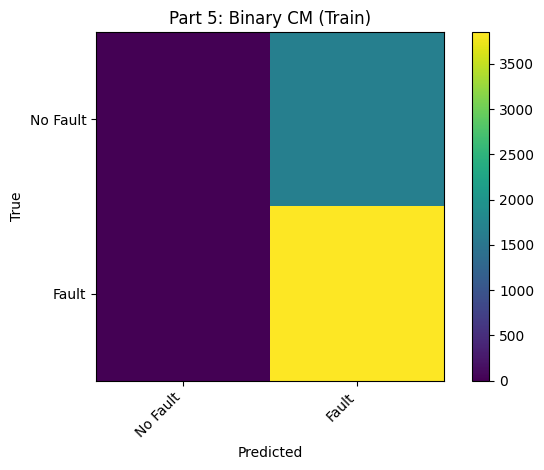

=== Binary Fault vs No Fault | Test ===
              precision    recall  f1-score   support

    No Fault     0.0000    0.0000    0.0000       710
       Fault     0.6990    1.0000    0.8229      1649

    accuracy                         0.6990      2359
   macro avg     0.3495    0.5000    0.4114      2359
weighted avg     0.4886    0.6990    0.5752      2359



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


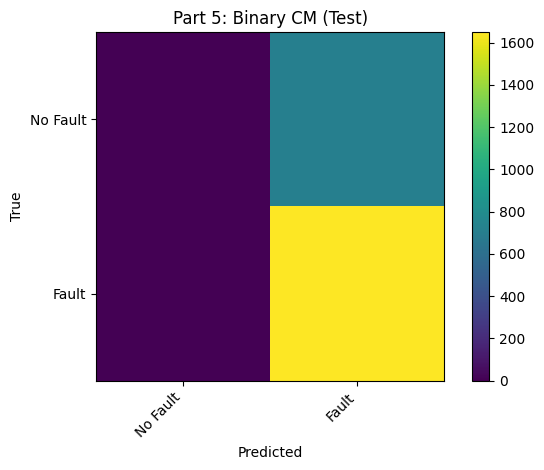

In [98]:
# ----------------------------
# Evaluation
# ----------------------------
pred_train = predict_part5(model, X_train_b)
pred_test  = predict_part5(model, X_test_b)


print("=== Binary Fault vs No Fault | Train ===")
print(classification_report(y_train_b, pred_train,
                            target_names=["No Fault","Fault"],
                            digits=4))
cm_tr5 = confusion_matrix(y_train_b, pred_train, labels=[0,1])
plot_cm(cm_tr5, "Part 5: Binary CM (Train)", ["No Fault","Fault"])

print("=== Binary Fault vs No Fault | Test ===")
print(classification_report(y_test_b, pred_test,
                            target_names=["No Fault","Fault"],
                            digits=4))
cm_te5 = confusion_matrix(y_test_b, pred_test, labels=[0,1])
plot_cm(cm_te5, "Part 5: Binary CM (Test)", ["No Fault","Fault"])
